In [1]:
import base64
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat

from sklearn.ensemble import RandomForestRegressor

pd.options.mode.chained_assignment = None


# IEEE Investment Ranking Challenge Starter Kit

This code contains a starter kit with examples of how to read in the data, perform some basic manipulation, and run a Random Forest model on each time period.

### Read Challenge Data and the Prediction Template
**Note**: This step assumes that you have downloaded the datasets from the [Datasets Page](https://www.crowdai.org/challenges/ieee-investment-ranking-challenge/dataset_files) and download the `Full Dataset` file and saved it inside the `data/` folder as `full_dataset.csv`; and then also download the `Prediction Template` file and saved it inside the `data/` folder as `prediction_template.csv`.

In [2]:
dataset_file_path = "data/full_dataset.csv"
pred_template_file_path = "data/prediction_template.csv"


# dataset_file_path = "YOUR_DATASET_FILE_PATH_HERE"
# pred_template_file_path = "YOUR_PREDICTION_TEMPLATE_FILE_PATH_HERE"

data = pd.read_csv(dataset_file_path)
pred_template = pd.read_csv(pred_template_file_path)

### Sample EDA

/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


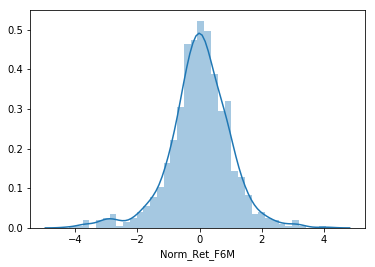

In [3]:
#create index to subset data from one time_period
index = data['time_period'] == '1996_2'

# View distribution of returns for first time_period
hist_1996_2 = sns.distplot(data.loc[index,'Norm_Ret_F6M'])
plt.show()

## Example Feature Engineering

Each unique variable is broken up into **6 non-overlapping observations** in each time period
For example `X1` has six monthly observations in each period represented as `X1_1`, `X1_2`,...,`X1_6`

To make it easier to model, this code will average the values within each `time_period`

In [4]:
#create list to iterate over
variable_list = ["X" + str(i) + '_' for i in range(1,71)]
        
for var in variable_list:
    data[var + 'avg'] = data.filter(regex=(var)).mean(axis = 1)

# create a new feature that is the percentile of each variable average rather than the raw value
# this is a common way to model the data as you are predicting stock performance relative to peers 
# using attributes that are also relative to peers

for var in variable_list:
    data[var + 'avg' + '_pctile'] = stat.rankdata(data[var + 'avg'])/data[var + 'avg'].shape[0]    

### Subset features to use for modeling. 
Subsetting `time_period`, `index`, `Train`, `Norm_Ret_F6M`, `Rank_F6M`, and the avg and percentile variables we created using  a regex filter for 'avg' to get both the avg and percentile columns only.

In [5]:
model_data = pd.concat([data.iloc[:,0:5],data.filter(regex = ('avg'))],axis=1)

### Create function for imputation and Random Forest

In [6]:
time_periods = np.unique(model_data['time_period'],return_index=True)[0]
time_periods_index = np.unique(model_data['time_period'],return_index=True)[1]

def randomForest(train_start_period,prediction_period):

    train_window_start = time_periods_index[time_periods == train_start_period][0]
    train_window_end = time_periods_index[time_periods == prediction_period][0]
    
    rf_model_data = model_data.iloc[range(train_window_start,train_window_end),:]
    
    rf_model_data.fillna(0,inplace = True)
    
    rf = RandomForestRegressor(n_estimators=1,verbose = 2,oob_score=True, max_features = 10)
    
    # fit using training data only (Train == 1)
    rf.fit(rf_model_data.loc[rf_model_data['Train'] == 1,'X1_avg':'X70_avg_pctile'], rf_model_data.loc[rf_model_data['Train'] == 1,'Norm_Ret_F6M'])
    
    return(rf)

### Create function for calculating spearman correlation and Normalized Discounted Cumulative Gain
**Note** : This function was incorrectly calculating NDCG as of the challenge launch. This was fixed 03/28. For details and questions, join the discussion [here.](https://www.crowdai.org/topics/notice-error-in-ndcg-calculation-in-evaluation-script/discussion)

In [7]:
def calc_metrics(time_period, predicted_rank):
    
    #subset actual values for prediction time_period
    actuals = model_data.loc[(model_data['time_period'] == time_period) & (model_data['Train'] == 1),:]
    
    #join predictions onto actuals
    actuals['Rank_F6M_pred'] = predicted_rank
    
    #calculate spearman correlation
    spearman = stat.spearmanr(actuals['Rank_F6M'],actuals['Rank_F6M_pred'])[0]
    
    # calculate NDCG = DCG of Top 20% / Ideal DCG of Top 20%
    # subset top 20% predictions
    t20 = actuals.loc[actuals['Rank_F6M_pred'] <= np.nanpercentile(actuals['Rank_F6M_pred'],20),:]
    t20['discount'] = np.amax(actuals['Rank_F6M_pred'])/(np.amax(actuals['Rank_F6M_pred'])+actuals['Rank_F6M_pred'])
    t20['gain'] = t20['Norm_Ret_F6M']*t20['discount']
    DCG = np.sum(t20['gain'])
    
    #subset top 20% actuals
    i20 = actuals.loc[actuals['Rank_F6M'] <= np.nanpercentile(actuals['Rank_F6M'],20),:]
    i20['discount'] = np.amax(actuals['Rank_F6M'])/(np.amax(actuals['Rank_F6M'])+actuals['Rank_F6M'])
    i20['gain'] = i20['Norm_Ret_F6M']*i20['discount']
    IDCG = np.sum(i20['gain'])
    
    NDCG = DCG/IDCG
    
    # return time_period, spearman correlation, NDCG
    return(pd.DataFrame([(time_period,spearman,NDCG)],columns = ['time_period','spearman','NDCG']))

### Random forest model on warm-up period

In [8]:
time = '2002_1'

rf = randomForest(train_start_period = '1996_2', prediction_period = time)

building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


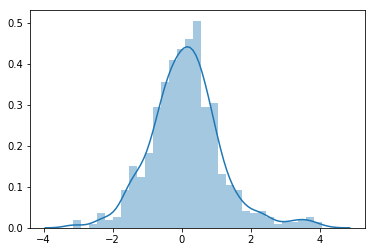

-0.30741861692141237


In [9]:
model_data.fillna(0,inplace = True)
predictions = rf.predict(model_data.loc[model_data['time_period'] == time,'X1_avg':'X70_avg_pctile'])

# view prediction histogram
pred_hist = sns.distplot(predictions)
plt.show()

# print Out-of-bag R^2
print(rf.oob_score_)

## Expanding window procedure
Expanding window = Train model up to time `t` to predict on all observations at time `t+1`   
* Show results on training data    
* Add test predictions to prediction template

In [10]:
model_data.fillna(0,inplace = True)
train_results = pd.DataFrame(columns=['time_period','spearman','NDCG'])

for time in time_periods[11:]:
    rf = randomForest(train_start_period = '1996_2', prediction_period = time)
    
    if(time != '2017_1'):
        train_predictions = rf.predict(model_data.loc[(model_data['time_period'] == time) & (model_data['Train'] == 1),'X1_avg':'X70_avg_pctile'])
        train_rank_predictions = len(train_predictions) - stat.rankdata(train_predictions,method='ordinal').astype(int) + 1
    
        train_results = train_results.append(calc_metrics(time_period = time, predicted_rank = train_rank_predictions))
        
    test_predictions = rf.predict(model_data.loc[(model_data['time_period'] == time) & (model_data['Train'] == 0),'X1_avg':'X70_avg_pctile'])
    test_rank_predictions = len(test_predictions) - stat.rankdata(test_predictions,method='ordinal').astype(int) + 1
    pred_template.loc[pred_template['time_period'] == time,'Rank_F6M'] = test_rank_predictions
    
    print("Time period " + time + " completed.")

print(train_results)

building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2002_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2002_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2003_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2003_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2004_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2004_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2005_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2005_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2006_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2006_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2007_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2007_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2008_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2008_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2009_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2009_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2010_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2010_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2011_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2011_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2012_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2012_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2013_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2013_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2014_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2014_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2015_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2015_2 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2016_1 completed.
building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Time period 2016_2 completed.
building tree 1 of 1
Time period 2017_1 completed.
  time_period  spearman      NDCG
0      2002_1 -0.025205 -0.080401
0      2002_2 -0.024251  0.148472
0      2003_1 -0.010054  0.050761
0      2003_2 -0.036487 -0.148286
0      2004_1  0.046961  0.039020
0      2004_2  0.131314  0.063422
0      2005_1 -0.017293 -0.034556
0      2005_2 -0.090445 -0.202651
0      2006_1  0.082887  0.037306
0      2006_2 -0.026440 -0.026647
0      2007_1 -0.039563 -0.131398
0      2007_2  0.142241  0.154048
0      2008_1 -0.057792 -0.118785
0      2008_2 -0.004884  0.053471
0      2009_1  0.068610  0.143744
0      2009_2 -0.054973 -0.065717
0      2010_1 -0.061288 -0.014116
0      2010_2  0.032757 -0.036734
0      2011_1 -0.033001 -0.049701
0      2011_2 -0.026918  0.086878
0      2012_1 -0.091682 -0.130979
0      2012_2  0.038147  0.111957
0      2013_1  0.041127 -0.003018
0      2013_2 -0.108488 -0.141649
0      2014_1 -0.023480 -0.115125
0      2014_2  0.071394  0.114048
0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
/ML_PROJECTS/CROWDAI/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### Write csv of test set predictions

In [11]:
pred_template.to_csv('rf_starter_kit_predictions.csv')

## Submit to crowdAI

In [12]:
import crowdai
import sys

In [13]:
api_key = "YOUR CROWDAI API KEY HERE"
encoded_api_key = "WU9VUiBDUk9XREFJIEFQSSBLRVkgSEVSRQ=="

if sys.version_info[0] == 3:
    api_key = api_key.encode()
    encoded_api_key = b"WU9VUiBDUk9XREFJIEFQSSBLRVkgSEVSRQ=="

if base64.b64encode(api_key) == encoded_api_key:
    raise Exception("Please include your own API Key from : https://www.crowdai.org/participants/<your-crowdai-username>")

challenge = crowdai.Challenge("IEEEInvestmentRankingChallenge", api_key)
result = challenge.submit("rf_starter_kit_predictions.csv")
print(result)


Exception: Please include your own API Key from : https://www.crowdai.org/participants/<your-crowdai-username>